In [298]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchquantum as tq
import random
from torchquantum.datasets import MNIST
from torch.optim.lr_scheduler import CosineAnnealingLR
from qiskit import IBMQ
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from torchquantum.plugins.qiskit_plugin import tq2qiskit
from torchquantum.encoding import encoder_op_list_name_dict
from torchquantum.layers import U3CU3Layer0

# Models

In [306]:
DEBUG = True

In [320]:
class QuanvolutionFilter(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
        [
            {'input_idx': [0], 'func': 'ry', 'wires': [0]},
            {'input_idx': [1], 'func': 'ry', 'wires': [1]},
            {'input_idx': [2], 'func': 'ry', 'wires': [2]},
            {'input_idx': [3], 'func': 'ry', 'wires': [3]},
        ])
        self.q_layer = tq.RandomLayer(n_ops=8, wires=list(range(self.n_wires)))
        self.measure = tq.MeasureAll(tq.PauliZ)
        
    def forward(self, x, use_qiskit=False):
        global DEBUG
        
        bsz = x.shape[0]
        size = 28
        x = x.view(bsz, size, size)
        data_list = []
        for c in range(0, size, 2):
            for r in range(0, size, 2):
                data = torch.transpose(torch.cat((x[:, c, r], x[:, c, r+1], x[:, c+1, r], x[:, c+1, r+1])).view(4, bsz), 0, 1)
                if DEBUG and c in [8, 10] and r in [8, 10]:
                    print('before\n', data)
                if use_qiskit:
                    data = self.qiskit_processor.process_parameterized(self.q_device, self.encoder, self.q_layer, self.measure, data)
                else:
                    self.encoder(self.q_device, data)
                    self.q_layer(self.q_device)
                    data = self.measure(self.q_device)
                    if DEBUG and c in [8, 10] and r in [8, 10]:
                        print('after\n', data)
                data_list.append(data.view(bsz, 4))
        result = torch.cat(data_list, dim=1).float()
#         print(f'caitao:{result.shape}')  # [10, 784]
        return result

In [321]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qf = QuanvolutionFilter()
        self.linear = torch.nn.Linear(4 * 14 * 14, 10)
    
    def forward(self, x, use_qiskit=False):
        with torch.no_grad():
            x = self.qf(x, use_qiskit)
        x = self.linear(x)
        return F.log_softmax(x, -1)

class HybridModel_without_qf(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(28*28, 10)
    
    def forward(self, x, use_qiskit=False):
        x = x.view(-1, 28*28)
        x = self.linear(x)
        return F.log_softmax(x, -1)

# Training

## Prepare data

In [195]:
dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio = [0.9, 0.1],
    n_test_samples=300,
    n_train_samples=500,
)
dataflow = dict()

for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=10,
        sampler=sampler,
        num_workers=8,
        pin_memory=True)


[2022-11-16 16:57:48.211] Only use the front 500 images as TRAIN set.
[2022-11-16 16:57:48.272] Only use the front 300 images as TEST set.


## Define Variables

In [318]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = HybridModel().to(device)
model_without_qf = HybridModel_without_qf().to(device)
n_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

## Start Training

### Quanvolution

In [189]:
accu_list1 = []
loss_list1 = []
accu_list2 = []
loss_list2 = []

def train(dataflow, model, device, optimizer, qiskit=False):
    for feed_dict in dataflow['train']:
        inputs = feed_dict['image'].to(device)
        targets = feed_dict['digit'].to(device)
        outputs = model(inputs, use_qiskit=qiskit)
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'loss: {loss.item()}', end='\r')

def valid_test(dataflow, split, model, device, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict['image'].to(device)
            targets = feed_dict['digit'].to(device)
            
            outputs = model(inputs, use_qiskit=qiskit)
            
            target_all.append(targets)
            output_all.append(outputs)
            
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()
    print(f'{split} set accuracy: {accuracy}')
    print(f'{split} set loss: {loss}')
    return accuracy, loss

for epoch in range(1, n_epochs + 1):
    # train
    print(f'epoch {epoch}:')
    train(dataflow, model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])
    
    #valid
    accu, loss = valid_test(dataflow, 'test', model, device)
    accu_list1.append(accu)
    loss_list1.append(loss)
    scheduler.step()

epoch 1:
0.005 0.54978096485137944
test set accuracy: 0.8066666666666666
test set loss: 0.6323181390762329
epoch 2:
0.00452254248593736853583
test set accuracy: 0.7666666666666667
test set loss: 0.5896801948547363
epoch 3:
0.00327254248593736830195
test set accuracy: 0.8733333333333333
test set loss: 0.46325933933258057
epoch 4:
0.00172745751406263148803
test set accuracy: 0.8466666666666667
test set loss: 0.4535667300224304
epoch 5:
0.00047745751406263162971
test set accuracy: 0.8733333333333333
test set loss: 0.420465886592865


### Classical

In [66]:
optimizer = optim.Adam(model_without_qf.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
for epoch in range(1, n_epochs + 1):
    # train
    print(f'Epoch {epoch}:')
    train(dataflow, model_without_qf, device, optimizer)
    print(optimizer.param_groups[0]['lr'])
    
    # valid
    accu, loss = valid_test(dataflow, 'test', model_without_qf, device)
    accu_list2.append(accu)
    loss_list2.append(loss)
    
    scheduler.step()

Epoch 1:
0.005 0.08121477067470556
test set accuracy: 0.7733333333333333
test set loss: 0.6043258905410767
Epoch 2:
0.00494536900183451490125
test set accuracy: 0.8166666666666667
test set loss: 0.5571644902229309
Epoch 3:
0.004783863644106502066654
test set accuracy: 0.8466666666666667
test set loss: 0.46128177642822266
Epoch 4:
0.0045225424859373685787456
test set accuracy: 0.8366666666666667
test set loss: 0.5158914923667908
Epoch 5:
0.004172826515897145533446
test set accuracy: 0.8666666666666667
test set loss: 0.45338067412376404
Epoch 6:
0.00375.012896935455501084
test set accuracy: 0.8466666666666667
test set loss: 0.4563254714012146
Epoch 7:
0.0032725424859373687004586
test set accuracy: 0.8566666666666667
test set loss: 0.46330180764198303
Epoch 8:
0.0027613211581691342325325
test set accuracy: 0.86
test set loss: 0.46147480607032776
Epoch 9:
0.0022386788418308679845665
test set accuracy: 0.85
test set loss: 0.45319321751594543
Epoch 10:
0.001727457514062632717926
test set acc

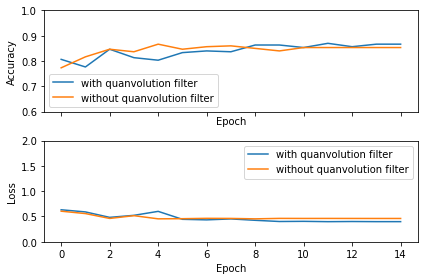

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(accu_list1, label="with quanvolution filter")
ax1.plot(accu_list2, label="without quanvolution filter")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0.6, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(loss_list1, label="with quanvolution filter")
ax2.plot(loss_list2, label="without quanvolution filter")
ax2.set_ylabel("Loss")
ax2.set_ylim([0, 2])
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## Checking the results

before
 tensor([[-0.0424,  2.6051,  0.0467,  2.7960],
        [ 2.7833,  2.7960,  2.7833,  2.7960],
        [-0.4242,  1.1414,  2.7960,  2.6815],
        [-0.4242, -0.4242, -0.4242,  0.2122],
        [ 2.7960,  2.7960,  2.7960,  0.7977],
        [-0.4242, -0.4242, -0.4242, -0.4242],
        [ 0.4286,  0.4413, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242],
        [-0.0042,  2.6051,  0.1995,  2.8088]], device='cuda:0')
after
 tensor([[ 0.5156,  0.1647,  0.7771, -0.9409],
        [-0.6852,  0.2647, -0.9622, -0.9409],
        [ 0.7125, -0.4972, -0.9587, -0.8960],
        [ 0.7125,  0.2332,  0.9781,  0.9776],
        [-0.6796, -0.1965, -0.9587,  0.6984],
        [ 0.7125,  0.2174,  0.9781,  0.9114],
        [ 0.1744,  0.5251,  0.9781,  0.9114],
        [ 0.7125,  0.2174,  0.9781,  0.9114],
        [ 0.7125,  0.2174,  0.9781,  0.9114],
        [ 0.4912,  0.1654,  0.6724, -0.9451]], device='cuda:0',
       grad_fn=<StackBackward

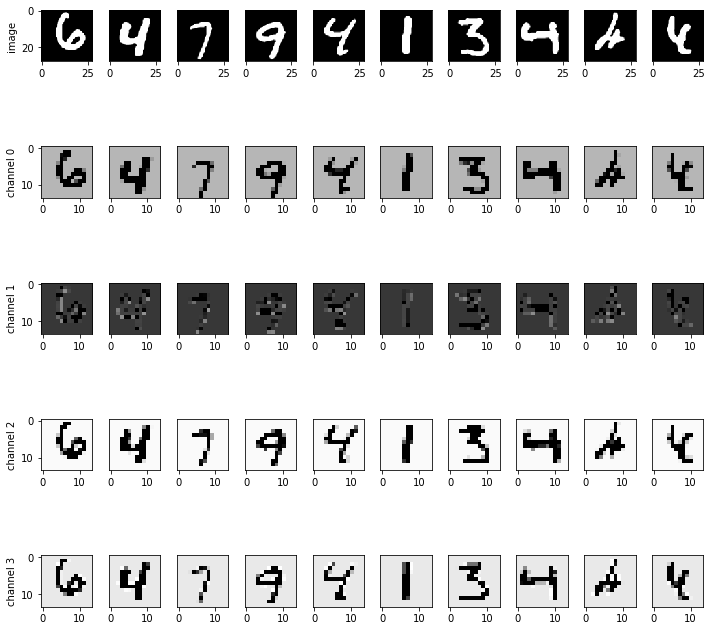

In [319]:
torch.manual_seed(42)
n_samples = 10
n_channels = 4
for feed_dict in dataflow['test']:
    inputs = feed_dict['image'].to(device)
    break
sample = inputs[:n_samples]
after_quanv = model.qf(sample).view(n_samples, 14*14, 4).cpu().detach().numpy()

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel('image')
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    axes[0, k].imshow(sample[k, 0, :, :].cpu(), norm=norm, cmap='gray')
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f'channel {c}')
        if k != 0:
            axes[c + 1, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(after_quanv[k, :, c].reshape(14, 14), norm=norm, cmap='gray')

plt.tight_layout()
plt.show()

# Comparing Models

In [322]:
class TrainableQuanvFilter(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
        [
            {'input_idx': [0], 'func': 'ry', 'wires': [0]},
            {'input_idx': [1], 'func': 'ry', 'wires': [1]},
            {'input_idx': [2], 'func': 'ry', 'wires': [2]},
            {'input_idx': [3], 'func': 'ry', 'wires': [3]}
        ])
        self.arch = {'n_wires': self.n_wires, 'n_blocks': 5, 'n_layers_per_block': 2}
        self.q_layer = U3CU3Layer0(self.arch)
        self.measure = tq.MeasureAll(tq.PauliZ)
    
    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        x = F.avg_pool2d(x, 6).view(bsz, 4, 4)
        size = 4
        stride = 2
        x = x.view(bsz, size, size)
        data_list = []
        for c in range(0, size, stride):
            for r in range(0, size, stride):
                data = torch.transpose(torch.cat((x[:, c, r], x[:, c, r+1], x[:, c+1, r], x[:, c+1, r+1])).view(4, bsz), 0, 1)
                if use_qiskit:
                    data = self.qiskit_processor.process_parameterized(self.q_device, self.encoder, self.q_layer, self.measure, data)
                else:
                    self.encoder(self.q_device, data)
                    self.q_layer(self.q_device)
                    data = self.measure(self.q_device)
                data_list.append(data.view(bsz, 4))
        # transpose to (bsz, channel, 2x2)
        result = torch.transpose(torch.cat(data_list, dim=1).view(bsz, 4, 4), 1, 2).float()
        return result

In [330]:
class QuantumClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=4)
        self.encoder = tq.GeneralEncoder(encoder_op_list_name_dict['4x4_ryzxy'])
        self.arch = {'n_wires': self.n_wires, 'n_blocks': 8, 'n_layers_per_block': 2}
        self.ansatz = U3CU3Layer0(self.arch)
        self.measure = tq.MeasureAll(tq.PauliZ)
    
    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        x = F.avg_pool2d(x, 6).view(bsz, 16)
        
        if use_qiskit:
            x = self.qiskit_processor.process_parameterized(self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(self.q_device, x)
            self.ansatz(self.q_device)
            x = self.measure(self.q_device)
        
        return x

In [324]:
class QFC(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(encoder_op_list_name_dict['4x4_ryzxy'])
        self.arch = {'n_wires': self.n_wires, 'n_blocks': 4, 'n_layers_per_block': 2}
        self.q_layer = U3CU3Layer0(self.arch)
        self.measure = tq.MeasureAll(tq.PauliZ)
        
    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        data = x
        if use_qiskit:
            data = self.qiskit_processor.process_parameterized(self.q_device, self.encoder, self.q_layer, self.measure, data)
        else:
            self.encoder(self.q_device, data)
            self.q_layer(self.q_device)
            data = self.measure(self.q_device)
        return data

In [326]:
class Model1(torch.nn.Module):
    '''Quanvolutional filter + FC layer'''
    def __init__(self):
        super().__init__()
        self.qf = TrainableQuanvFilter()
        self.linear = torch.nn.Linear(16, 4)
        
    def forward(self, x, use_qiskit=False):
        x = x.view(-1, 28, 28)
        x = self.qf(x)
        x = x.reshape(-1, 16)
        x = self.linear(x)
        return F.log_softmax(x, -1)


class Model2(torch.nn.Module):
    '''Quanvolutional filter + QFC layer'''
    def __init__(self):
        super().__init__()
        self.qf = TrainableQuanvFilter()
        self.qfc = QFC()
    
    def forward(self, x, use_qiskit=False):
        x = x.view(-1, 28, 28)
        x = self.qf(x)
        x = x.reshape(-1, 16)
        x = self.qfc(x)
        return F.log_softmax(x, -1)

    
class Model3(torch.nn.Module):
    '''QFC layer'''
    def __init__(self):
        super().__init__()
        self.qfc = QuantumClassifier()
    
    def forward(self, x, use_qiskit=False):
        x = self.qfc(x)
        return F.log_softmax(x,  -1)

    
class Model4(torch.nn.Module):
    '''purely classical FC + FC layer'''
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(16, 9)
        self.linear2 = torch.nn.Linear(9, 4)
    
    def forward(self, x, use_qiskit=False):
        x = x.view(-1, 28, 28)
        bsz = x.shape[0]
        x = F.avg_pool2d(x, 6).view(bsz, 16)
        x = self.linear1(x)
        x = self.linear2(x)
        return F.log_softmax(x, -1)

In [327]:
dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio=[0.9, 0.1],
    digits_of_interest=[0, 1, 2, 3],
    n_test_samples=300,
    n_train_samples=500
)

dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=10,
        sampler=sampler,
        num_workers=8,
        pin_memory=True
    )

[2022-11-16 22:54:01.734] Only use the front 500 images as TRAIN set.
[2022-11-16 22:54:01.799] Only use the front 300 images as TEST set.


In [333]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
accus = []

model_list = [Model1().to(device), Model2().to(device), Model3().to(device), Model4().to(device)]
for model in model_list:
    n_epochs = 15
    optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
    for epoch in range(1, n_epochs + 1):
        print(f'Epoch {epoch}:')
        # train
        train(dataflow, model, device, optimizer)
        print(optimizer.param_groups[0]['lr'])
        # valid
        accu, loss = valid_test(dataflow, 'test', model, device)
        scheduler.step()
    accus.append(accu)

Epoch 1:
0.005 0.9917079806327827
test set accuracy: 0.65
test set loss: 1.1016355752944946
Epoch 2:
0.0049453690018345140229
test set accuracy: 0.7166666666666667
test set loss: 0.8723611235618591
Epoch 3:
0.00478386364410650208646
test set accuracy: 0.73
test set loss: 0.7488658428192139
Epoch 4:
0.00452254248593736858335
test set accuracy: 0.7766666666666666
test set loss: 0.6627289056777954
Epoch 5:
0.00417282651589714552974
test set accuracy: 0.7766666666666666
test set loss: 0.6183658242225647
Epoch 6:
0.00375.52516859769821176
test set accuracy: 0.76
test set loss: 0.6131730079650879
Epoch 7:
0.00327254248593736872075
test set accuracy: 0.7866666666666666
test set loss: 0.5894365906715393
Epoch 8:
0.00276132115816913444666
test set accuracy: 0.7833333333333333
test set loss: 0.5635955333709717
Epoch 9:
0.00223867884183086750736
test set accuracy: 0.7766666666666666
test set loss: 0.5911928415298462
Epoch 10:
0.00172745751406263282095
test set accuracy: 0.79
test set loss: 0.5631

In [334]:
for i, accu in enumerate(accus):
    print(f'accuracy of model{i+1}: {accu}')

accuracy of model1: 0.8033333333333333
accuracy of model2: 0.7133333333333334
accuracy of model3: 0.7533333333333333
accuracy of model4: 0.8333333333333334
